In [104]:
import ROOT
import uproot
import copy 
import math
import operator
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import optimize
import pylab

In [ ]:
%%script env bash
    
shifter --module=cvmfs --image=luxzeplin/offline_hosted:centos7 /bin/bash
    
cd /global/u1/m/mrw7816/AlpacaAnalysis

export OUTDIR=/global/u1/m/mrw7816/AlpacaAnalysis/run/InteactionFinderDev

source setup.sh

source build.sh

python analysisScripts/RunNJobs_localDataset.py -d /global/cfs/cdirs/lz/data/MDC3/background/LZAP-4.8.3/20180410/*root* -o IFdev.root -n 12 -m InteractionFinderDev

In [ ]:
%%script env bash
python analysisScripts/RunNJobs_localDataset.py -d /global/cfs/cdirs/lz/data/MDC3/background/LZAP-4.8.3/20180410/*root* -o IFdev.root -n 12 -m InteractionFinderDev

In [ ]:
ROOT.gStyle.SetPalette(ROOT.kRainBow)
ROOT.gStyle.SetOptStat(111111)
colors=[ROOT.kBlue, ROOT.kRed, ROOT.kGreen, ROOT.kOrange, ROOT.kMagenta, ROOT.kCyan, ROOT.kViolet, ROOT.kPink, ROOT.kSpring, ROOT.kTeal]
def get_hist(rfile, histname):
    hist = rfile.Get(histname)
    return copy.deepcopy(hist)
def get_keynames(self, dir=""):
    self.cd(dir)
    return [key.GetName() for key in ROOT.gDirectory.GetListOfKeys()]
def format_hist(hist, j, histname):
    hist.SetMarkerStyle(7)
    hist.SetMarkerColor(colors[j] + 2)
    hist.SetLineColor(colors[j] + 2)
    hist.SetLineWidth(2)
    hist.SetMarkerColorAlpha(colors[j] + 2, 0.4)
    #hist.GetXaxis().SetTitle("pbf");
    #hist.GetYaxis().SetTitle("TBA");
    hist.GetXaxis().SetTitleOffset(1.5);
    hist.GetYaxis().SetTitalOffset(1.5);
def setup_canvas(fileloc, histList, ncols=3, logx=False, logy=False, logz=False, drawtype='vs'):
    rfile=ROOT.TFile(fileloc)
    nrows = int(math.ceil(len(histList)/ncols))
    canvas = ROOT.TCanvas("c","c",ncols*500, nrows*500)
    canvas.Divide(ncols, nrows)
    for i, histName in enumerate(histList):
        canvas.cd(i + 1)
        print(histName)
        stack = ROOT.THStack()
        thisHist = get_hist(rfile, histName)
        thisHist.SetTitle(histName)     
        axis = thisHist.GetXaxis()
        #axis.SetTitle("csize")
        axis.SetRangeUser(9E-4, 1)
        axis1 = thisHist.GetYaxis()
        #axis1.SetTitle("TBA")
        axis1.SetRangeUser(0, 1000)
        stack.Add(thisHist)
        if logx:
            canvas.cd(i+1).SetLogx()
        if logy:
            canvas.cd(i+1).SetLogy()
        if logz:
            canvas.cd(i+1).SetLogz()
        if drawtype == 'vs':
            thisHist.Draw('colz')
        else:
            thisHist.Draw('histo')
    return canvas

In [ ]:
histList=["all/all_s1_s2","all/all_s1ratio_h2w_allS1s","all/all_s2ratio_h2w_allS2s"]
fileloc='/global/homes/m/mrw7816/AlpacaAnalysis/run/InteractionFinderDev/IFdev.root'
ss = setup_canvas(fileloc, histList, ncols=1,logy=True,logx=True)
ss.Draw()

In [105]:
x = np.array([0.31836401756865057
,0.2782559402207126
,0.2601385279477476
,0.2601385279477476
,0.2601385279477476
,0.23994790313880157
,0.23673856230543763
,0.24649769667586263
,0.2936542274344944
,0.327054314743274
,0.3545745842465601
,0.3792690190732246
,0.38962182373389426
,0.38441057074055013
,0.36919130312117865
,0.3792690190732246
,0.3545745842465601
,0.38441057074055013
,0.2601385279477476
,0.23994790313880157])
y = np.array([0.09858000137488755
,0.07841694843423472
,0.04822028952697204
,0.037275937203149416
,0.021036881784318846
,0.01492495545051832
,0.007954650775061854
,0.004489251258218616
,0.0031849717901176818
,0.003674661940736695
,0.004753556207866379
,0.00670018750350959
,0.00917768017464651
,0.01580366313960628
,0.024271307232444063
,0.04961947603002903
,0.07841694843423472
,0.03520333844240511
,0.027213387683753087
,0.006149217801737426])

In [88]:
from numpy.linalg import eig, inv
def polyToParams(v,printMe):

   # convert the polynomial form of the ellipse to parameters
   # center, axes, and tilt
   # v is the vector whose elements are the polynomial
   # coefficients A..F
   # returns (center, axes, tilt degrees, rotation matrix)

   #Algebraic form: X.T * Amat * X --> polynomial form

   Amat = np.array(
   [
   [v[0],     v[1]/2.0, v[3]/2.0],
   [v[1]/2.0, v[2],     v[4]/2.0],
   [v[3]/2.0, v[4]/2.0, v[5]    ]
   ])

   if printMe: print('\nAlgebraic form of polynomial\n',Amat)

   #See B.Bartoni, Preprint SMU-HEP-10-14 Multi-dimensional Ellipsoidal Fitting
   # equation 20 for the following method for finding the center
   A2=Amat[0:2,0:2]
   A2Inv=inv(A2)
   ofs=v[3:5]/2.0
   cc = -np.dot(A2Inv,ofs)
   if printMe: print('\nCenter at:',cc)

   # Center the ellipse at the origin
   Tofs=np.eye(3)
   Tofs[2,0:2]=cc
   R = np.dot(Tofs,np.dot(Amat,Tofs.T))
   if printMe: print('\nAlgebraic form translated to center\n',R,'\n')

   R2=R[0:2,0:2]
   s1=-R[2, 2]
   RS=R2/s1
   (el,ec)=eig(RS)

   recip=1.0/np.abs(el)
   axes=np.sqrt(recip)
   if printMe: print('\nAxes are\n',axes  ,'\n')

   rads=np.arctan2(ec[1,0],ec[0,0])
   deg=np.degrees(rads) #convert radians to degrees (r2d=180.0/np.pi)
   if printMe: print('Rotation is ',deg,'\n')

   inve=inv(ec) #inverse is actually the transpose here
   if printMe: print('\nRotation matrix\n',inve)
   return (cc[0],cc[1],axes[0],axes[1],deg,inve)

In [89]:
def printAns(pv,xin,yin,verbose):
  print('\nPolynomial coefficients, F term is -1:\n',pv)

  #normalize and make first term positive
  nrm=np.sqrt(np.dot(pv,pv))
  enrm=pv/nrm
  if enrm[0] < 0.0:
     enrm = - enrm
  print('\nNormalized Polynomial Coefficients:\n',enrm)

  #convert polynomial coefficients to parameterized ellipse (center, axes, and tilt)
  #also returns rotation matrix in last parameter
  # either pv or normalized parameter will work
  # params = polyToParams(enrm,verbose)

  params = polyToParams(pv,verbose)

  print("\nCenter at  %10.4f,%10.4f (truth is 1.5,  1.5)" % (params[0],params[1]))
  print("Axes gains %10.4f,%10.4f (truth is 1.55, 1.0)" % (params[2],params[3]))
  print("Tilt Degrees %10.4f (truth is 30.0)" % (params[4]))

  R=params[5]
  print('\nRotation Matrix\n',R)

  # Check solution
  # Convert to unit sphere centered at origin
  #  1) Subtract off center
  #  2) Rotate points so bulges are aligned with x, y axes (no xy term)
  #  3) Scale the points by the inverse of the axes gains
  #  4) Back rotate
  # Rotations and gains are collected into single transformation matrix M

  # subtract the offset so ellipse is centered at origin
  xc=xin-params[0]
  yc=yin-params[1]

  # create transformation matrix
  L = np.diag([1/params[2],1/params[3]])
  M=np.dot(R.T,np.dot(L,R))
  print('\nTransformation Matrix\n',M)

  # apply the transformation matrix
  [xm,ym]=np.dot(M,[xc,yc])
  # Calculate distance from origin for each point (ideal = 1.0)
  rm = np.sqrt(xm*xm + ym*ym)

  print("\nAverage Radius  %10.4f (truth is 1.0)" % (np.mean(rm)))
  print("Stdev of Radius %10.4f " % (np.std(rm)))

In [90]:
#least squares fit to an ellipse
# A x^2 + B xy + C y^2 + Dx + Ey = 1
#
# Returns coefficients A..F
# A x^2 + B xy + C y^2 + Dx + Ey + F = 0
# where F = -1

def ls_ellipse(xx,yy):

   # change xx from vector of length N to Nx1 matrix so we can use hstack
   x = xx[:,np.newaxis]
   y = yy[:,np.newaxis]

   J = np.hstack((x*x, x*y, y*y, x, y))
   K = np.ones_like(x) #column of ones

   JT=J.transpose()
   JTJ = np.dot(JT,J)
   InvJTJ=np.linalg.inv(JTJ);
   ABC= np.dot(InvJTJ, np.dot(JT,K))

   # ABC has polynomial coefficients A..E
   # Move the 1 to the other side and return A..F
   # A x^2 + B xy + C y^2 + Dx + Ey - 1 = 0
   eansa=np.append(ABC,-1)

   return eansa

In [91]:
if __name__ == '__main__':

# Test of least squares fit to an ellipse
# Samples have random noise added to both X and Y components
# True center is at (1.5, 1.5);
# X axis is 1.55, Y axis is 1.0, tilt is 30 degrees
# (or -150 from symmetry)
#
# Polynomial coefficients, F term is -1:
# A x^2 + B xy + C y^2 + Dx + Ey - 1 = 0
#
# A= -0.53968362, B=  0.50979868, C= -0.8285294
# D=  0.87914926, E=  1.72765849, F= -1

# Polynomial coefficients after normalization:
# A x^2 + B xy + C y^2 + Dx + Ey + F = 0
#
# A=  0.22041087, B= -0.20820563, C=  0.33837767
# D= -0.3590512,  E= -0.70558878  F=  0.40840756

# Test data, no noise
   x0 = np.array([ 0.0289278,0.0254332,0.0244882,0.262155,0.3168,0.374235,0.0360329,0.0349577,0.0341724,0.0298176,0.0287096,0.0289278])

   y0 = np.array([0.009664,0.00256944,0.000683155,0.000280615,0.000328705,0.000937365,0.00237405,0.00677008,0.0110985,0.0110985,0.009664,0.009664])

# Test data with added noise
   xnoisy = np.array([ 0.0289278,0.0254332,0.0244882,0.262155,0.3168,0.374235,0.0360329,0.0349577,0.0341724,0.0298176,0.0287096,0.0289278])

   ynoisy = np.array([0.009664,0.00256944,0.000683155,0.000280615,0.000328705,0.000937365,0.00237405,0.00677008,0.0110985,0.0110985,0.009664,0.009664])

   print('\n==============================')
   print('\nSolution for Perfect Data (to 4 decimal places)')

   ans0= ls_ellipse(x0,y0)
   printAns(ans0,x0,y0,0)

   print('\n==============================')
   print('\nSolution for Noisy Data')

   ans = ls_ellipse(xnoisy,ynoisy)
   printAns(ans,xnoisy,ynoisy,0)



Solution for Perfect Data (to 4 decimal places)

Polynomial coefficients, F term is -1:
 [-2.90979062e+01  1.43759856e+03 -1.91315281e+04  1.15470917e+01
  2.18193052e+02 -1.00000000e+00]

Normalized Polynomial Coefficients:
 [ 1.51656404e-03 -7.49267064e-02  9.97122861e-01 -6.01826946e-04
 -1.13720807e-02  5.21193528e-05]

Center at      4.7201,    0.1830 (truth is 1.5,  1.5)
Axes gains     4.7043,    0.0491 (truth is 1.55, 1.0)
Tilt Degrees  -177.8481 (truth is 30.0)

Rotation Matrix
 [[-0.99929479 -0.03754905]
 [ 0.03754905 -0.99929479]]

Transformation Matrix
 [[ 0.24097905 -0.75595284]
 [-0.75595284 20.33078257]]

Average Radius      1.0005 (truth is 1.0)
Stdev of Radius     0.0022 


Solution for Noisy Data

Polynomial coefficients, F term is -1:
 [-2.90979062e+01  1.43759856e+03 -1.91315281e+04  1.15470917e+01
  2.18193052e+02 -1.00000000e+00]

Normalized Polynomial Coefficients:
 [ 1.51656404e-03 -7.49267064e-02  9.97122861e-01 -6.01826946e-04
 -1.13720807e-02  5.21193528e-05

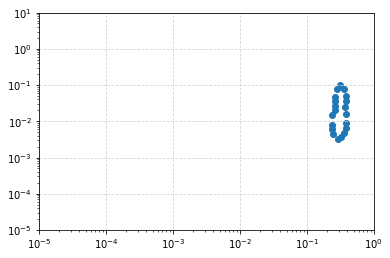

In [109]:
from math import pi
plt.scatter(x,y)
u=4.7201     #x-position of the center
v=0.1830    #y-position of the center
a=4.7043     #radius on the x-axis
b=0.0491    #radius on the y-axis
t = np.linspace(10E-1, 2*pi, 1)
plt.plot( u+a*np.cos(t) , v+b*np.sin(t) )
plt.grid(color='lightgray',linestyle='--')
plt.xlim(10e-6,1)
plt.ylim(10e-6,10)
plt.yscale('log')
plt.xscale('log')